In [1]:
from keras.datasets import fashion_mnist
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print(tf.__version__)

2.12.0


In [2]:
def load_data():
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    print(f"Train shape: {train_images.shape}")
    print(f"Test shape: {test_images.shape}")
    return train_images, train_labels, test_images, test_labels, class_names

train_images, train_labels, test_images, test_labels, class_names = load_data()

Train shape: (60000, 28, 28)
Test shape: (10000, 28, 28)


In [3]:
def preprocess_data(train_images, test_images):
    train_images = train_images / 255.0
    test_images = test_images / 255.0
    return train_images, test_images

train_images, test_images = preprocess_data(train_images, test_images)

In [4]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

In [5]:
def lr_scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch > 0:
        lr = lr / 2
    return lr


def k_fold_cross_validation(k, train_images, train_labels, learning_rate, num_epochs=15, batch_size=64, optimizer='adam', verbose=0, loss='sparse_categorical_crossentropy', metrics=['accuracy']):
    num_val_samples = len(train_images) // k
    all_scores = []
    all_loss = []

    for i in range(k):
        print('processing fold #', i)
        val_data = train_images[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = train_labels[i * num_val_samples: (i + 1) * num_val_samples]
        partial_train_data = np.concatenate(
            [train_images[:i * num_val_samples],
            train_images[(i + 1) * num_val_samples:]],
            axis=0)
        partial_train_targets = np.concatenate(
            [train_labels[:i * num_val_samples],
            train_labels[(i + 1) * num_val_samples:]],
            axis=0)
        model = create_model()
        # use optimizer based on the input
        if optimizer == 'adam':
            opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        elif optimizer == 'sgd':
            opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
        elif optimizer == 'rmsprop':
            opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
        else:
            opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
        model.compile(optimizer=opt,
                    loss=loss,
                    metrics=metrics)
        model.fit(partial_train_data, partial_train_targets,
                epochs=num_epochs, batch_size=batch_size, verbose=verbose, callbacks=[callback])
        val_loss, val_acc = model.evaluate(val_data, val_targets, verbose=0)
        all_scores.append(val_acc)
        all_loss.append(val_loss)
    return all_scores, all_loss



def plot_k_fold_cross_validation(all_scores):
    # bar chart of accuracy
    min = np.min(all_scores)
    max = np.max(all_scores)
    delta = max - min
    plt.bar(range(len(all_scores)), all_scores)
    plt.title('Accuracy Scores')
    plt.xlabel('Folds')
    plt.ylabel('Accuracy')
    plt.ylim(min - delta * 0.1, max + delta * 0.1)
    plt.xticks(range(len(all_scores)))
    plt.show()
    # boxplot
    sns.boxplot(all_scores)
    plt.title('Accuracy Scores')
    plt.xlabel('10 folds')
    plt.ylabel('Accuracy')
    # no ticks
    plt.xticks([])
    plt.show()


def plot_k_fold_cross_validation_loss(all_loss):
    min = np.min(all_loss)
    max = np.max(all_loss)
    delta = max - min
    plt.bar(range(len(all_loss)), all_loss)
    plt.title('Loss Scores')
    plt.xlabel('Folds')
    plt.ylabel('Loss')
    plt.ylim(min - delta * 0.1, max + delta * 0.1)
    plt.xticks(range(len(all_loss)))
    plt.show()

In [6]:

all_scores, all_loss = k_fold_cross_validation(10, train_images, train_labels, learning_rate=0.001, num_epochs=15, batch_size=64, optimizer='adam', verbose=0, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9


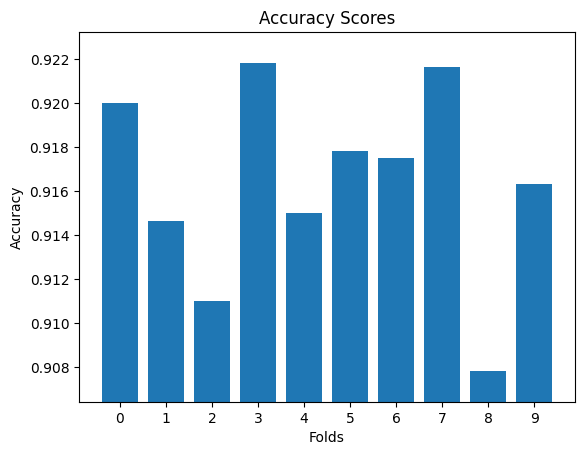

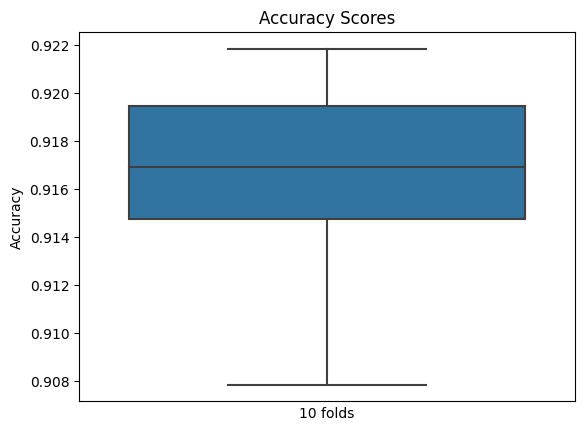

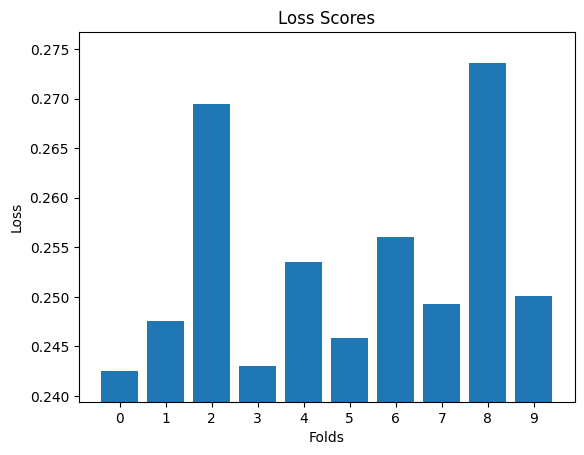

In [7]:
plot_k_fold_cross_validation(all_scores)
plot_k_fold_cross_validation_loss(all_loss)

In [16]:
model = create_model()

# Train the model
def train_model(train_images, train_labels , model):
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
    model.compile(optimizer=opt,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    history = model.fit(train_images, train_labels, epochs=15, batch_size=64, callbacks=[callback])
    return model, history

model, history = train_model(train_images, train_labels, model)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=1)

print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

Epoch 1/15
938/938 [==============================] - 14s 15ms/step - loss: 0.5433 - accuracy: 0.7995 - lr: 0.0010
Epoch 2/15
938/938 [==============================] - 14s 15ms/step - loss: 0.3391 - accuracy: 0.8768 - lr: 0.0010
Epoch 3/15
938/938 [==============================] - 15s 16ms/step - loss: 0.2902 - accuracy: 0.8954 - lr: 0.0010
Epoch 4/15
938/938 [==============================] - 15s 16ms/step - loss: 0.2629 - accuracy: 0.9037 - lr: 0.0010
Epoch 5/15
938/938 [==============================] - 14s 15ms/step - loss: 0.2362 - accuracy: 0.9129 - lr: 0.0010
Epoch 6/15
938/938 [==============================] - 14s 15ms/step - loss: 0.1972 - accuracy: 0.9277 - lr: 5.0000e-04
Epoch 7/15
938/938 [==============================] - 14s 15ms/step - loss: 0.1829 - accuracy: 0.9328 - lr: 5.0000e-04
Epoch 8/15
938/938 [==============================] - 15s 15ms/step - loss: 0.1711 - accuracy: 0.9370 - lr: 5.0000e-04
Epoch 9/15
938/938 [==============================] - 15s 15ms/step 

In [9]:
# plot the model
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [10]:
history.history

{'loss': [0.5304469466209412,
  0.3364485800266266,
  0.2901788353919983,
  0.2592147886753082,
  0.23766010999679565,
  0.19859150052070618,
  0.18445540964603424,
  0.17343240976333618,
  0.16181084513664246,
  0.15223413705825806,
  0.12888993322849274,
  0.12186019122600555,
  0.11690154671669006,
  0.11026584357023239,
  0.10500608384609222],
 'accuracy': [0.8068833351135254,
  0.8784666657447815,
  0.8933333158493042,
  0.904116690158844,
  0.9126666784286499,
  0.9262166619300842,
  0.9318166375160217,
  0.9351999759674072,
  0.9392333626747131,
  0.9431999921798706,
  0.9532166719436646,
  0.9555000066757202,
  0.9570500254631042,
  0.9593666791915894,
  0.9627166390419006],
 'lr': [0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.0005,
  0.0005,
  0.0005,
  0.0005,
  0.0005,
  0.00025,
  0.00025,
  0.00025,
  0.00025,
  0.00025]}

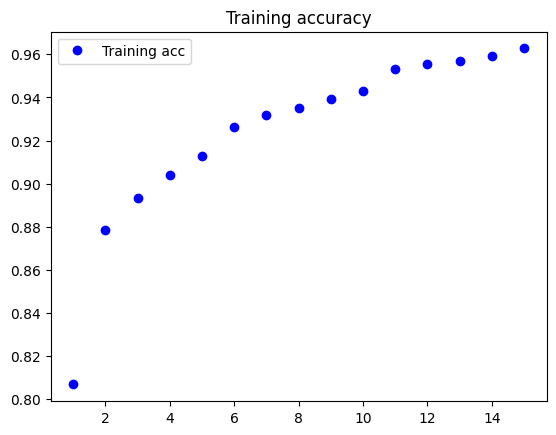

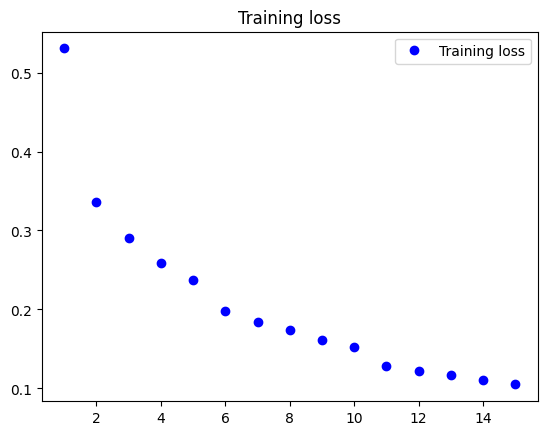

In [11]:
# plot loss and accuracy
def plot_loss_and_accuracy(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.title('Training accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.title('Training loss')
    plt.legend()
    plt.show()

plot_loss_and_accuracy(history)

Epoch 1/15
938/938 [==============================] - 22s 23ms/step - loss: 0.5401 - accuracy: 0.8022 - lr: 0.0010
Epoch 2/15
938/938 [==============================] - 23s 25ms/step - loss: 0.3496 - accuracy: 0.8729 - lr: 0.0010
Epoch 3/15
938/938 [==============================] - 24s 26ms/step - loss: 0.3044 - accuracy: 0.8882 - lr: 0.0010
Epoch 4/15
938/938 [==============================] - 23s 25ms/step - loss: 0.2772 - accuracy: 0.8983 - lr: 0.0010
Epoch 5/15
938/938 [==============================] - 22s 24ms/step - loss: 0.2572 - accuracy: 0.9048 - lr: 0.0010
Epoch 6/15
938/938 [==============================] - 22s 23ms/step - loss: 0.2205 - accuracy: 0.9177 - lr: 5.0000e-04
Epoch 7/15
938/938 [==============================] - 22s 23ms/step - loss: 0.2080 - accuracy: 0.9222 - lr: 5.0000e-04
Epoch 8/15
938/938 [==============================] - 22s 23ms/step - loss: 0.1983 - accuracy: 0.9255 - lr: 5.0000e-04
Epoch 9/15
938/938 [==============================] - 23s 24ms/step 

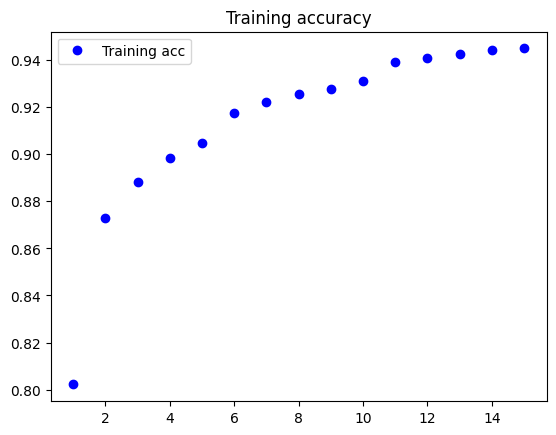

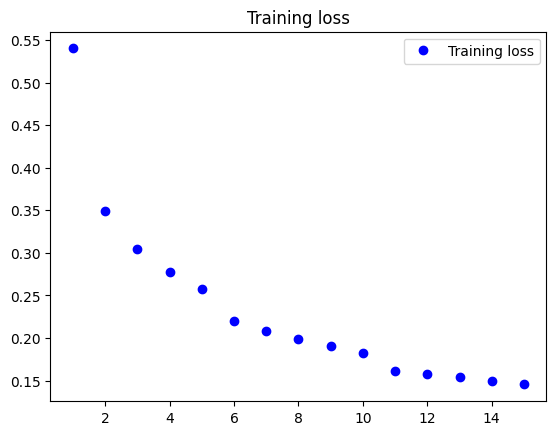

In [29]:
#Dropout inclussion after second maxpooling
#Dropout prevents overfitting by dropping a random weight (.5= 50% chance to happen)
#Dropout reduces correlation between neurons
def create_model_variant1():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

model = create_model_variant1()

model, history = train_model(train_images, train_labels, model)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=1)

print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

plot_loss_and_accuracy(history)

#Result: Dropout variant is  better than baseline on the test data but trains worse. More epochs probably required to train it properly since it drops data so often.
# However since its dropping weights so often it does less overfitting and outperforms the baseline on the test data.
#Conclussion: loss: 0.2573 - accuracy: 0.9191 Baseline - loss: 0.2413 - accuracy: 0.9146 Variant1

Epoch 1/15
938/938 [==============================] - 15s 15ms/step - loss: 0.6542 - accuracy: 0.7927 - lr: 0.0010
Epoch 2/15
938/938 [==============================] - 14s 15ms/step - loss: 0.4305 - accuracy: 0.8603 - lr: 0.0010
Epoch 3/15
938/938 [==============================] - 15s 15ms/step - loss: 0.3740 - accuracy: 0.8786 - lr: 0.0010
Epoch 4/15
938/938 [==============================] - 15s 16ms/step - loss: 0.3409 - accuracy: 0.8882 - lr: 0.0010
Epoch 5/15
938/938 [==============================] - 14s 15ms/step - loss: 0.3193 - accuracy: 0.8935 - lr: 0.0010
Epoch 6/15
938/938 [==============================] - 15s 15ms/step - loss: 0.2864 - accuracy: 0.9053 - lr: 5.0000e-04
Epoch 7/15
938/938 [==============================] - 15s 16ms/step - loss: 0.2774 - accuracy: 0.9078 - lr: 5.0000e-04
Epoch 8/15
938/938 [==============================] - 15s 16ms/step - loss: 0.2676 - accuracy: 0.9119 - lr: 5.0000e-04
Epoch 9/15
938/938 [==============================] - 15s 16ms/step 

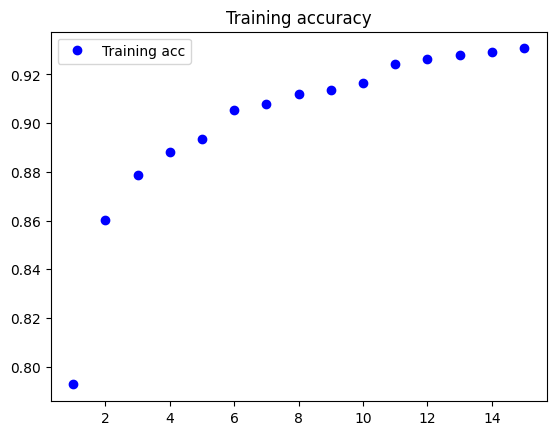

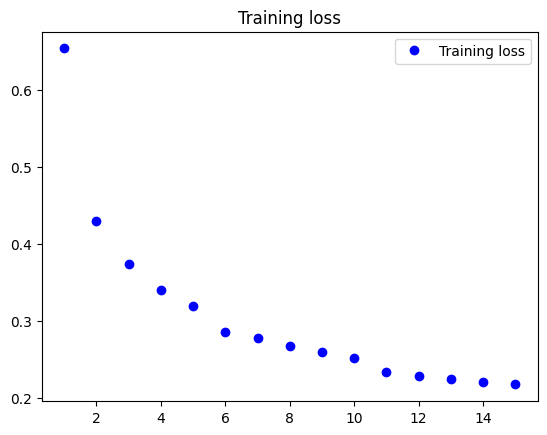

In [25]:
#L1 Regularization: Penalize weight values
#L1 prevents overfitting by slowly melting large weight values
def create_model_variant2():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), kernel_regularizer='l1'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

model = create_model_variant2()

model, history = train_model(train_images, train_labels, model)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=1)

print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

plot_loss_and_accuracy(history)

#Result: L1 variant is slightly worse than baseline on the test data and trains worse. 
# More epochs are required to get full value.
#Conclussion: loss: 0.2573 - accuracy: 0.9191 Baseline - loss: 0.2925 - accuracy: 0.9040 Variant2

Epoch 1/15
938/938 [==============================] - 22s 23ms/step - loss: 0.4159 - accuracy: 0.8504 - lr: 0.0010
Epoch 2/15
938/938 [==============================] - 21s 22ms/step - loss: 0.2810 - accuracy: 0.8974 - lr: 0.0010
Epoch 3/15
938/938 [==============================] - 21s 22ms/step - loss: 0.2448 - accuracy: 0.9096 - lr: 0.0010
Epoch 4/15
938/938 [==============================] - 21s 23ms/step - loss: 0.2201 - accuracy: 0.9195 - lr: 0.0010
Epoch 5/15
938/938 [==============================] - 21s 22ms/step - loss: 0.1971 - accuracy: 0.9262 - lr: 0.0010
Epoch 6/15
938/938 [==============================] - 21s 22ms/step - loss: 0.1466 - accuracy: 0.9458 - lr: 5.0000e-04
Epoch 7/15
938/938 [==============================] - 21s 23ms/step - loss: 0.1302 - accuracy: 0.9516 - lr: 5.0000e-04
Epoch 8/15
938/938 [==============================] - 21s 23ms/step - loss: 0.1136 - accuracy: 0.9579 - lr: 5.0000e-04
Epoch 9/15
938/938 [==============================] - 21s 23ms/step 

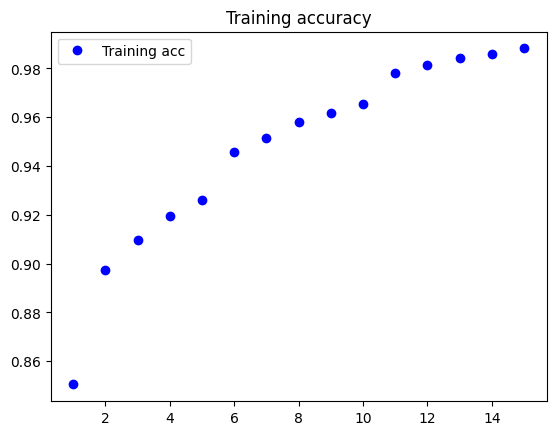

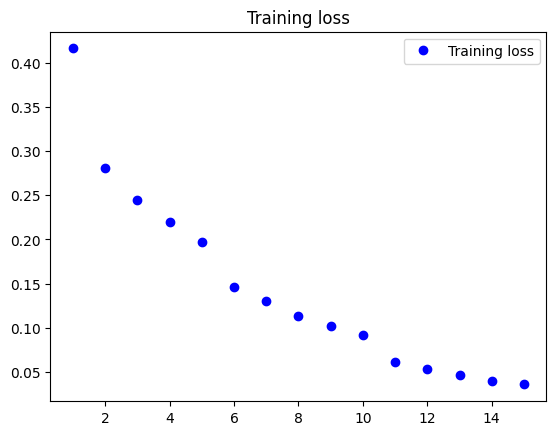

In [27]:
#Batch normalization: Stabilize learning process
#Normalizes values to 0 or to 1 depending on whichever they are closer to using mean and std, solves internal covariate shift.
# Forces every layer to have the same distribution in every epoch
def create_model_variant3():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

model = create_model_variant3()

model, history = train_model(train_images, train_labels, model)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=1)

print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

plot_loss_and_accuracy(history)

#Result: Batch normalization trains excelently BUT will need more epochs to improve validation accuracy.
#This variant could also largely improve by adding a dropping layer and regulizers to reduce overfitting (but we can only have 1 change per variant)
#Conclussion: loss: 0.2573 - accuracy: 0.9191 Baseline - loss: 0.3936 - accuracy: 0.9103 Variant3

Epoch 1/15
938/938 [==============================] - 15s 16ms/step - loss: 0.5853 - accuracy: 0.7919 - lr: 0.0010
Epoch 2/15
938/938 [==============================] - 15s 16ms/step - loss: 0.3770 - accuracy: 0.8689 - lr: 0.0010
Epoch 3/15
938/938 [==============================] - 15s 16ms/step - loss: 0.3295 - accuracy: 0.8842 - lr: 0.0010
Epoch 4/15
938/938 [==============================] - 16s 17ms/step - loss: 0.2982 - accuracy: 0.8950 - lr: 0.0010
Epoch 5/15
938/938 [==============================] - 15s 16ms/step - loss: 0.2757 - accuracy: 0.9035 - lr: 0.0010
Epoch 6/15
938/938 [==============================] - 16s 17ms/step - loss: 0.2405 - accuracy: 0.9155 - lr: 5.0000e-04
Epoch 7/15
938/938 [==============================] - 15s 16ms/step - loss: 0.2287 - accuracy: 0.9203 - lr: 5.0000e-04
Epoch 8/15
938/938 [==============================] - 15s 16ms/step - loss: 0.2175 - accuracy: 0.9247 - lr: 5.0000e-04
Epoch 9/15
938/938 [==============================] - 17s 18ms/step 

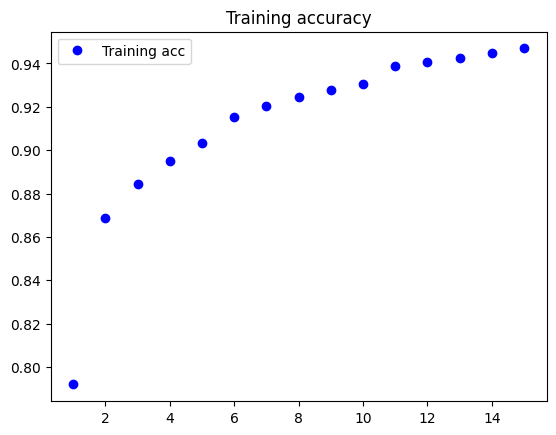

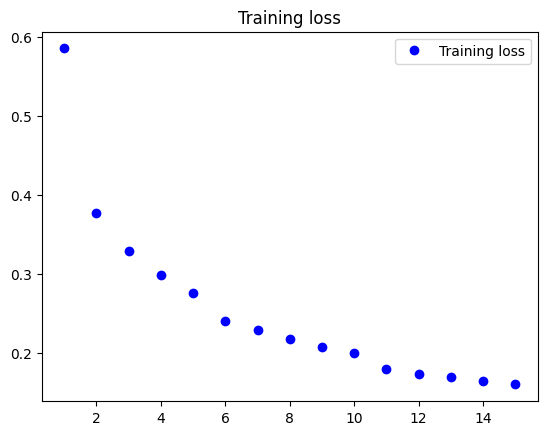

In [28]:
#L2 Regularization: Penalize weight by dissolving high values by their squared magnitude
#L2 prevents overfitting by slowly melting large weight values
def create_model_variant4():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), kernel_regularizer='l2'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

model = create_model_variant4()

model, history = train_model(train_images, train_labels, model)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=1)

print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

plot_loss_and_accuracy(history)

#Result: L2 variant is slightly worse than baseline on the train data but the accuracy seems better on the validation, however we can see that
# it is overfitted in the train data.
# More epochs and additional overfitting prevention layers would improve this variant.
#Conclussion: loss: 0.2573 - accuracy: 0.9191 Baseline - loss: 0.2718 - accuracy: 0.9113 Variant4